In [8]:
from app.app import App
import random as rd
import itertools
import numpy as np
import time
import matplotlib.pyplot as plt

from utils.population import Population
from utils.pipe import Pipe

In [9]:
window_width, window_height = 800, 600

n_birds = 32 # Number of birds in our population
n_reproducers = int(np.ceil(0.10 * n_birds)) # Number of birds that are allowed to reproduce
print(f"n_reproducers {n_reproducers}")
# reproducers = []
genomes = None # Initial genome of the birds will be randomly generated
mutation_rate = 0.02

dt = 40 # ms
time_since_last_pipe = 0
dist_between_pipes = 400
floor_height = 50
floor_frontier = (200, window_height - floor_height)
ceiling_frontier = (200, 0)

max_distances = []

n_reproducers 4


In [10]:
n_generations = 10

In [11]:
# This Function takes the indices of the reproducers after the generation test and returns a list of new genomes for the next generation.
def get_next_generation_genomes(population):
    # Getting the best birds' genomes
    print("Getting the best birds' genomes")
    selected_genomes = [population.brains[reproducer_index].genome for reproducer_index in population.reproducers]
    print(f"Selected {len(selected_genomes)} Genomes.")

    # Creating n_birds new genomes by crossing over the selected genomes
    print("Creating n_birds new genomes by crossing over the selected genomes")
    new_genomes = []
    for i in range(n_birds):
        i1 = np.random.randint(0, len(selected_genomes))
        i2 = np.random.randint(0, len(selected_genomes))
        while i1 == i2: # making sure i1 and i2 are different
            i2 = np.random.randint(0, len(selected_genomes))
        
        genome_parent1 = selected_genomes[i1]
        genome_parent2 = selected_genomes[i2]

        # crossover_point = np.random.randint(0, len(genome_parent1))
        crossover_rate = rd.random()
        crossover_points = {k: int(crossover_rate * genome_parent1[k].size) for k in genome_parent1.keys()}

        # To create the genome of the child we take each layers of both parents and we take the weights
        # of the first parent's genome until the crossover point and we finish with the second parent's
        # genome.
        genome_child = {
            k: np.concatenate((
                genome_parent1[k].flatten()[:crossover_points[k]],
                genome_parent2[k].flatten()[crossover_points[k]:]
            )).reshape(genome_parent1[k].shape)
            for k in genome_parent1.keys()
        }
        new_genomes.append(genome_child)

    # Mutations on the newborns
    print(f"Mutations on the newbords (mutation rate: {mutation_rate})")
    # The mutation is a natural process when you create an new child. Here we do random mutations
    # with the probability of mutation_rate, which means each weight or bias of the neural
    # network has a probability of mutation_rate to be randomly modified. To minimise the
    # complexity, we create a mutation_mask which decides which values will be modified. Then we
    # create an array where all the values have been modified, and finally we update the values
    # of the layer which have been chosen by the mutation_mask to give them the value of the
    # newly created array mutated_values.
    mutated_genomes = []
    for new_genome in new_genomes:
        mutated_genome = {}
        for k in new_genome:
            layer = new_genome[k].copy()
            # print(f"layer.shape {layer.shape}")
            mutation_mask = np.random.rand(len(layer)) < mutation_rate
            mutated_values = np.random.uniform(low=np.min(layer), high=np.max(layer), size=layer.shape)
            # print(f"mutated_values.shape {mutated_values.shape}")
            layer[mutation_mask] = mutated_values[mutation_mask]
            mutated_genome[k] = layer
        mutated_genomes.append(mutated_genome)

    return mutated_genomes

In [12]:
for i in range(n_generations):
    print("#"*150)
    print(f"GENERATION {i}")
    print("#"*150)
    # Creating the Population
    print("Creating the Population")
    population = Population(n_birds=n_birds, n_reproducers=n_reproducers, genomes=genomes)
    # Generating the Pipes²
    print("Generating the Pipes")
    pipe1 = Pipe(window_dim=(window_width, window_height), height=300)
    pipe_speed = pipe1.speed
    pipes = [pipe1]

    # Used just for not choosing several times the same reproducers
    reproducers_selected = False

    # Used to record the performance of the best bird of the current generation
    max_dist = 0

    # Launching the Generation Simulation
    print("Launching the Generation Simulation")
    running = True
    while running:
        # Moving the pipes
        for pipe in pipes:
            pipe.move()
        # Generating new pipes (no acceleration of the pipes)
        dist_since_last_pipe = (pipe_speed / dt) * time_since_last_pipe
        if dist_since_last_pipe >= dist_between_pipes:
            new_pipe_height = rd.randint(0, window_height - 200 - floor_height)
            new_pipe = Pipe(window_dim=(window_width, window_height), height=new_pipe_height)
            pipes.append(new_pipe)
            time_since_last_pipe = 0
        # Making the birds fly
        population.fly()
        # Updating the max_dist with the distance done after this time step
        max_dist += pipe_speed * dt

        print("Making the Birds Flap")
        outputs = []
        for i, brain in enumerate(population.brains):
            input = population.birds[i,:]
            output = brain.get_response(input)
            outputs.append(output.detach().numpy()[0])  # output is a tensor with 1 elt so we detach it, convert to numpy and then get the only elt to get a float
        flap_indices = [i for i, value in enumerate(outputs) if value > 0]
        # Some birds might be dead so we don't take them
        real_flap_indices = [ind for ind in flap_indices if population.birds[ind, 3]]
        print(f"{len(flap_indices)} Birds are selected to flap but {len(real_flap_indices)} are alive.")
        population.flap(index=real_flap_indices)

        # Collision
        global_frontier = [floor_frontier] + [ceiling_frontier] + list(itertools.chain(*[curr_pipe.frontier for curr_pipe in pipes])) # concatenating all the frontiers
        # print(f"frontier {frontier}")
        reproducers = population.kill(global_frontier, floor_frontier, ceiling_frontier)

        # Condition for stopping the simulation
        running = False if population.all_birds_dead() else True

        # making time run
        time_since_last_pipe += dt

    # Printing the best distance
    print(f"The best Bird of Generation {i} achieved a distance of {max_dist}")
    max_distances.append(max_dist)
    
    # Creating the next generation
    print("Creating the next generation")
    # genomes = mutated_genomes
    genomes = get_next_generation_genomes(population=population)

######################################################################################################################################################
GENERATION 0
######################################################################################################################################################
Creating the Population
Population -> __init__ : initialising the brains of the birds
Generating the Pipes
Launching the Generation Simulation
Making the Birds Flap
12 Birds are selected to flap but 12 are alive.
Making the Birds Flap
13 Birds are selected to flap but 13 are alive.
Making the Birds Flap
13 Birds are selected to flap but 13 are alive.
Making the Birds Flap
13 Birds are selected to flap but 13 are alive.
Making the Birds Flap
12 Birds are selected to flap but 12 are alive.
Making the Birds Flap
13 Birds are selected to flap but 13 are alive.
Making the Birds Flap
12 Birds are selected to flap but 12 are alive.
Making the Birds Flap
12 Birds are selected to flap 

Best Distances: [26320, 25200, 40600, 28840, 23240, 24360, 25760, 24080, 32480, 35000]


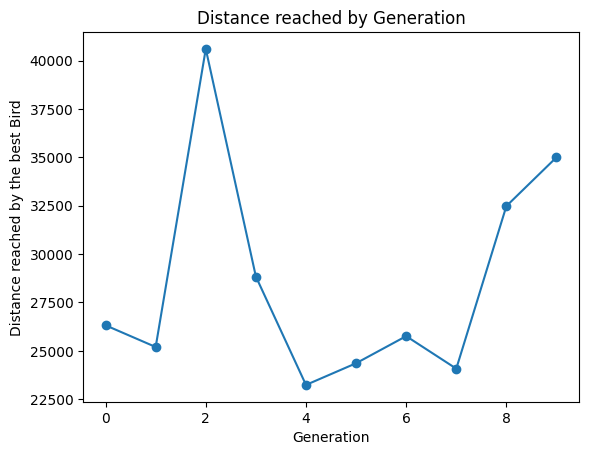

In [13]:
print(f"Best Distances: {max_distances}")

plt.plot(max_distances, 'o-')
plt.title('Distance reached by Generation')
plt.xlabel('Generation')
plt.ylabel('Distance reached by the best Bird')
plt.show()